# Parcellation

Goal: Compare HCP and DK atlases

## Setup

In [1]:
# Import modules and R
import numpy as np, pandas as pd
from plotnine import *
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [9]:
# Import local code
import sys
sys.path.append('../code')
import pcaVersion
from processing_helpers import *
from analysis_helpers import *
from brainspan import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");

In [4]:
data_dir = "~/rds/rds-cam-psych-transc-Pb9UGUlrwWc/Cam_LIBD/AHBA_data/abagen-data/expression/"
hcp_base = pcaVersion(pd.read_csv(data_dir + 'hcp_base.csv', index_col=0))
hcp_3donors_ds8 = pcaVersion(pd.read_csv(data_dir + 'hcp_3donors_ds8.csv', index_col=0))

New PCA version
New PCA version


In [19]:
dk_expression, stability = get_expression_abagen(atlas=fetch_dk(native=True), donors_threshold=0, DS_threshold=0, save_name='dk_native_base', return_stability=True)

In [21]:
stability.to_csv("../outputs/stability_dk.csv")

In [24]:
dk_base = pcaVersion(get_expression_abagen(atlas=fetch_dk(native=True), donors_threshold=0, DS_threshold=0, save_name='dk_base'))
dk_ds5 = pcaVersion(get_expression_abagen(atlas=fetch_dk(native=True), donors_threshold=0, DS_threshold=0.5, save_name='dk_ds5'))
dk_3donors_ds5 = pcaVersion(get_expression_abagen(atlas=fetch_dk(native=True), donors_threshold=3, DS_threshold=0.5, save_name='dk_3donors_ds5'))
dk_3donors_ds8 = pcaVersion(get_expression_abagen(atlas=fetch_dk(native=True), donors_threshold=3, DS_threshold=0.8, save_name='dk_3donors_ds8'))

New PCA version
7973 genes remain after filtering for top 0.5 differential stability
New PCA version
7973 genes remain after filtering for top 0.5 differential stability
New PCA version
3190 genes remain after filtering for top 0.2 differential stability
New PCA version


In [12]:
dk_ds4 = pcaVersion(get_expression_abagen(atlas=fetch_dk(native=True), donors_threshold=0, DS_threshold=0.4, save_name='dk_ds4'))
dk_ds3 = pcaVersion(get_expression_abagen(atlas=fetch_dk(native=True), donors_threshold=0, DS_threshold=0.3, save_name='dk_ds3'))
dk_ds2 = pcaVersion(get_expression_abagen(atlas=fetch_dk(native=True), donors_threshold=0, DS_threshold=0.2, save_name='dk_ds2'))

9568 genes remain after filtering for top 0.6 differential stability
New PCA version
11162 genes remain after filtering for top 0.7 differential stability
New PCA version
12757 genes remain after filtering for top 0.8 differential stability
New PCA version


In [5]:
dk_base = pcaVersion(pd.read_csv(data_dir + 'dk_base.csv', index_col=0))
dk_ds5 = pcaVersion(pd.read_csv(data_dir + 'dk_ds5.csv', index_col=0))
dk_3donors_ds5 = pcaVersion(pd.read_csv(data_dir + 'dk_3donors_ds5.csv', index_col=0))
dk_3donors_ds8 = pcaVersion(pd.read_csv(data_dir + 'dk_3donors_ds8.csv', index_col=0))

New PCA version
New PCA version
New PCA version
New PCA version


In [16]:
corrs_dict = {
    'DK 3-donors DS 0.8': hcp_3donors_ds8.corr_coefs(dk_3donors_ds8),
    'DK 3-donors DS 0.5': hcp_3donors_ds8.corr_coefs(dk_3donors_ds5),
    'DK DS 0.5': hcp_3donors_ds8.corr_coefs(dk_ds5),
    'DK DS 0.4': hcp_3donors_ds8.corr_coefs(dk_ds4),
    'DK DS 0.3': hcp_3donors_ds8.corr_coefs(dk_ds3),
    'DK DS 0.2': hcp_3donors_ds8.corr_coefs(dk_ds2),
    # 'HCP 3d 0.8 vs DK base': hcp_3donors_ds8.corr_coefs(dk_base),
}
df_corrs = (pd.concat(corrs_dict)
            .stack().reset_index()
            .set_axis(['version','x','y','corr'],axis=1)
           )

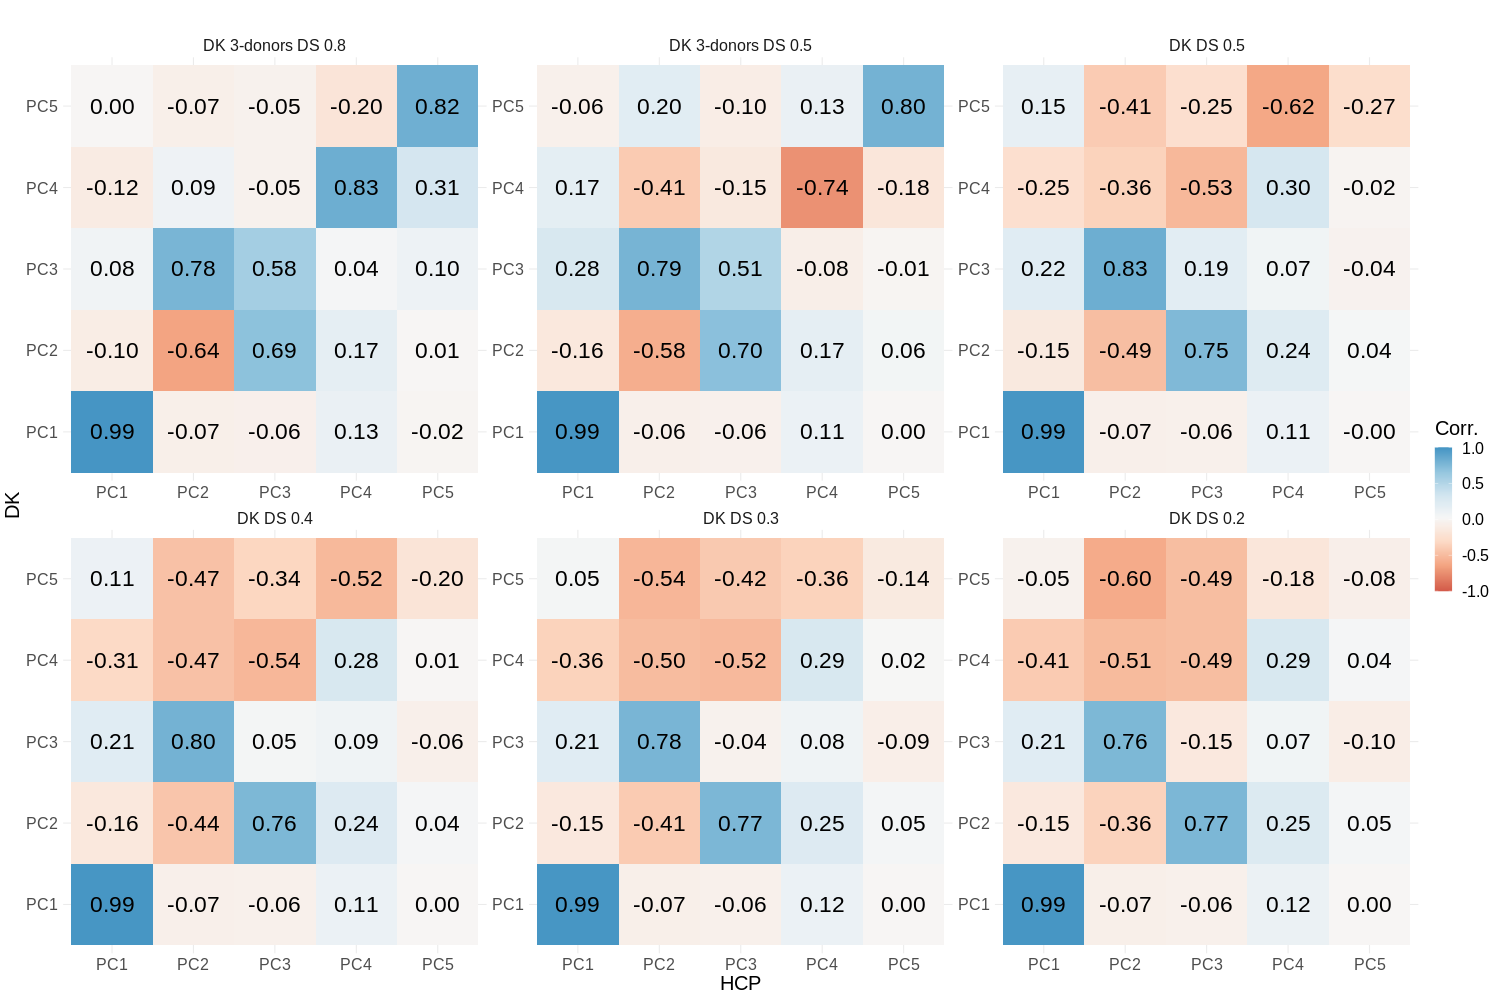

In [17]:
%%R -w 1500 -h 1000 -i df_corrs
plot_corrs(df_corrs, facetting='w') & theme(text=element_text(size=20))

In [9]:
corrs_dict = {
    'Base': hcp_native_base.corr_coefs(dk_native_base),
    '3D DS5': hcp_native_3donors_ds5.corr_coefs(dk_native_3donors_ds5),
    '3D DS8': hcp_native_3donors_ds8.corr_coefs(dk_native_3donors_ds8),
}
df_corrs = (pd.concat(corrs_dict)
            .stack().reset_index()
            .set_axis(['version','x','y','corr'],axis=1)
           )

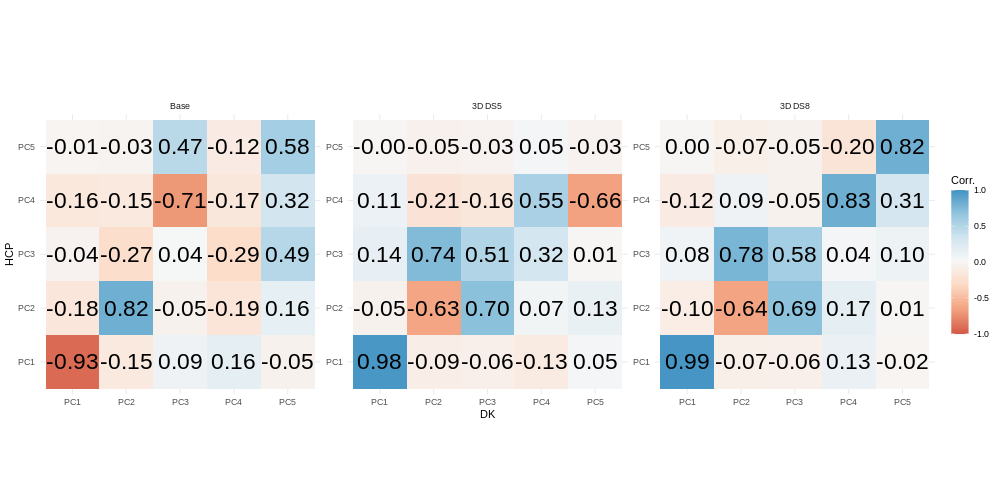

In [10]:
%%R -w 1000 -h 500 -i df_corrs
plot_corrs(df_corrs)